/Users/ryanlin/miniconda3/envs/gino-pino/lib/python3.12/site-packages/torch/__init__.py
2.2.2


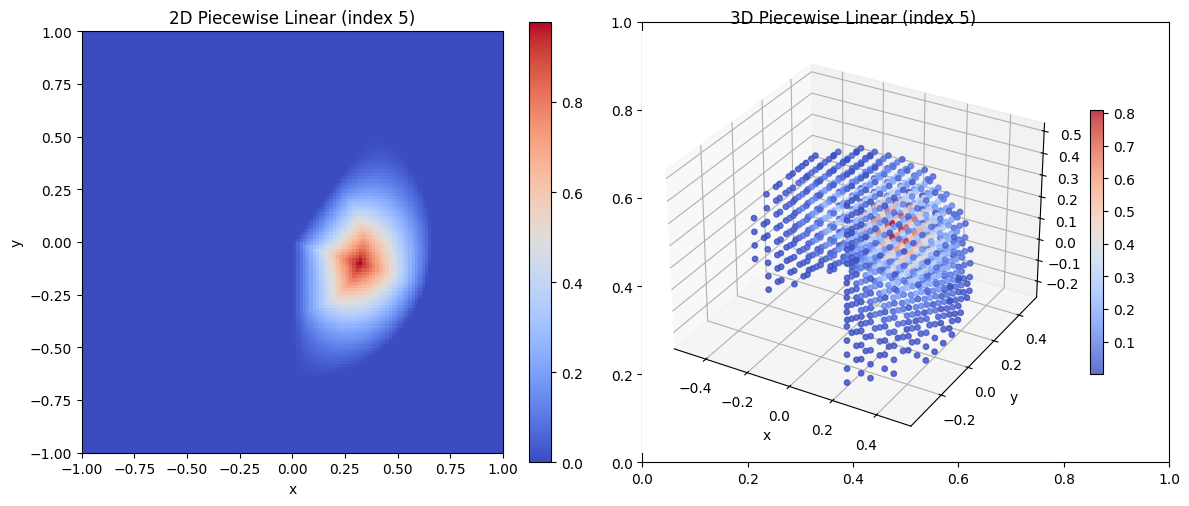

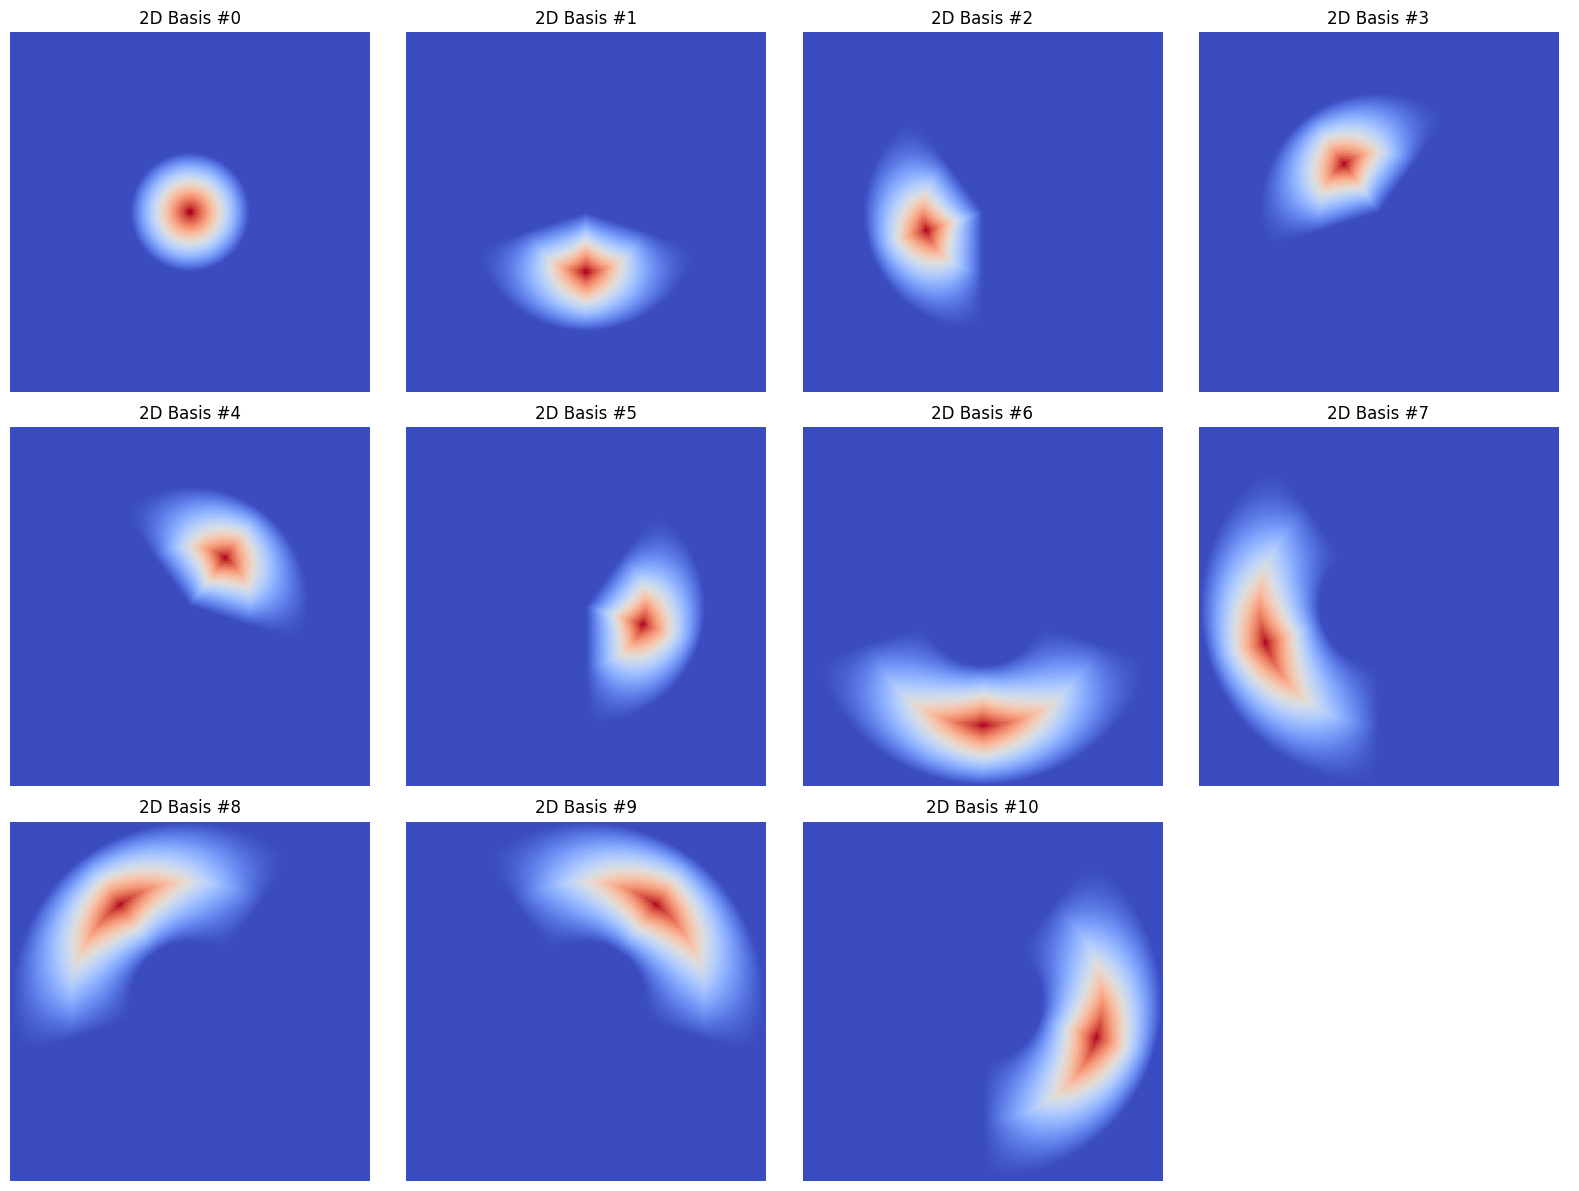

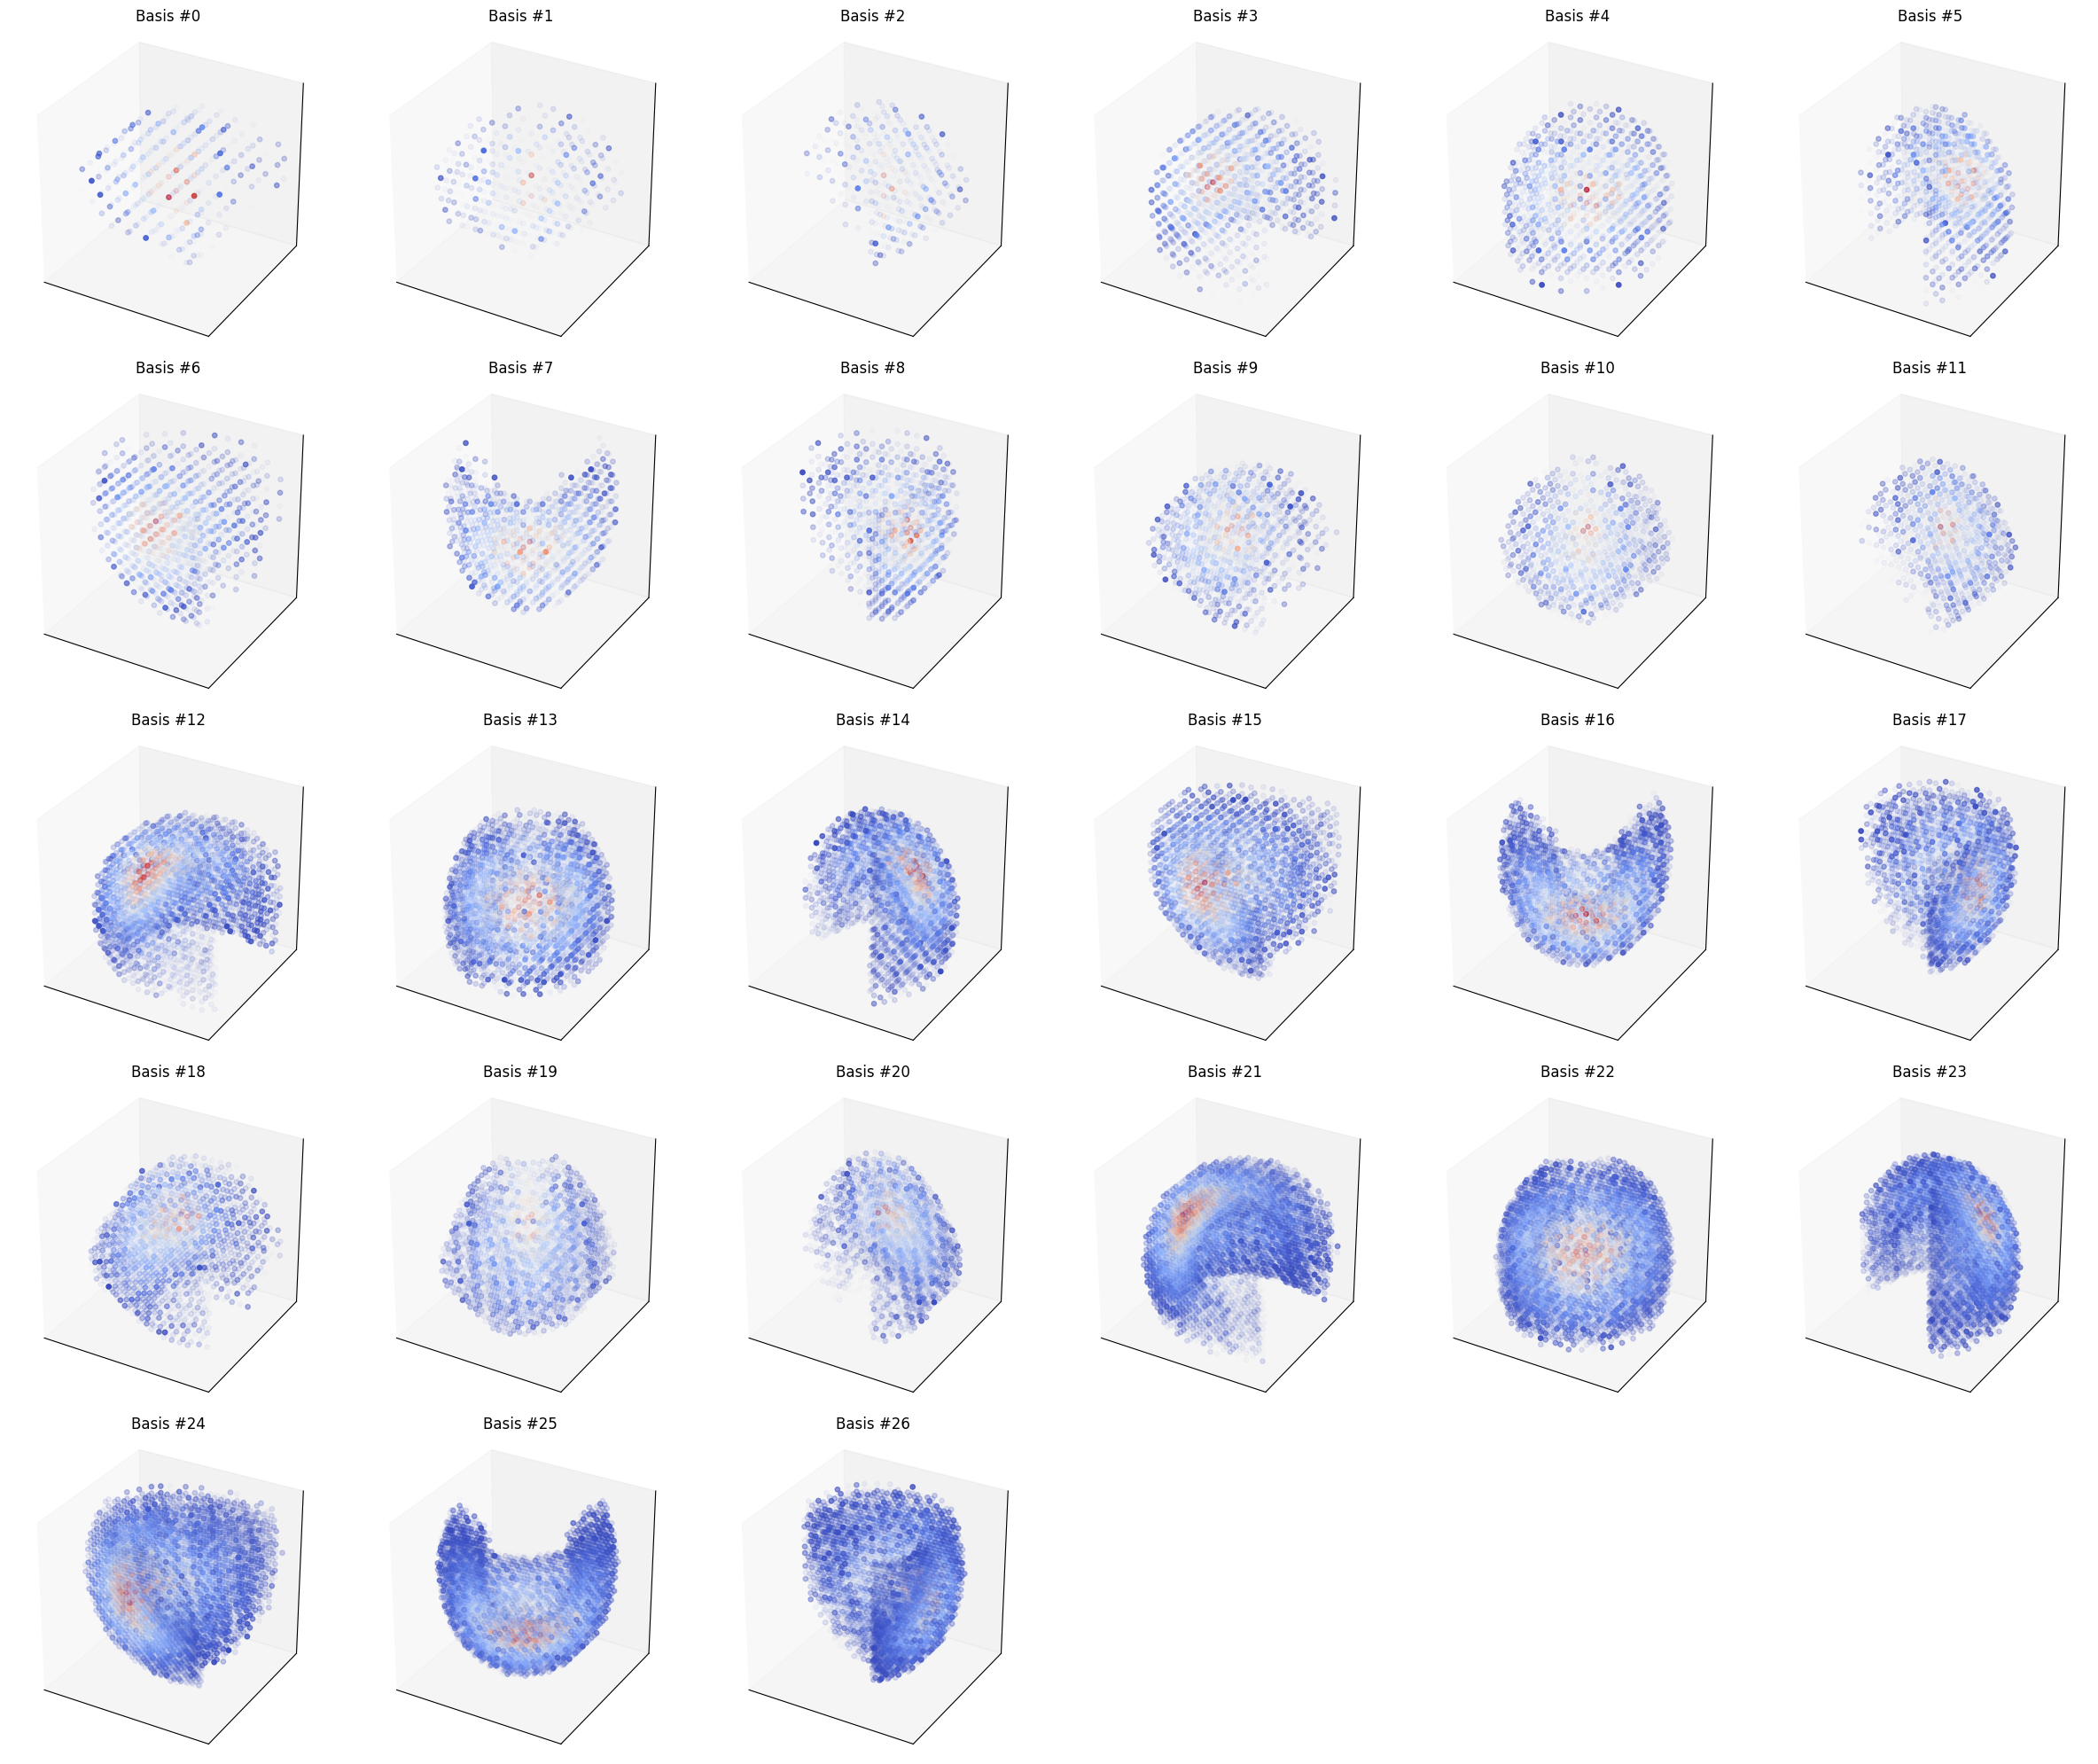

In [21]:
# %%
# # Compare 2D vs 3D Piecewise Linear Filter Bases
import sys
import os
import abc

local_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # parent folder of notebooks/
sys.path.insert(0, local_path)

import torch
print(torch.__file__)
print(torch.__version__)
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple, Union, Optional
import math
from typing_extensions import override

def _circle_dist(x1: torch.Tensor, x2: torch.Tensor):
    """Helper function to compute the distance on a circle"""
    return torch.minimum(torch.abs(x1 - x2), torch.abs(2 * math.pi - torch.abs(x1 - x2)))


def _log_factorial(x: torch.Tensor):
    """Helper function to compute the log factorial on a torch tensor"""
    return torch.lgamma(x + 1)


def _factorial(x: torch.Tensor):
    """Helper function to compute the factorial on a torch tensor"""
    return torch.exp(_log_factorial(x))

class FilterBasis(metaclass=abc.ABCMeta):
    """
    Abstract base class for a filter basis
    """

    def __init__(
        self,
        kernel_shape: Union[int, Tuple[int], Tuple[int, int], Tuple[int, int, int]],
    ):

        self.kernel_shape = kernel_shape

    @property
    @abc.abstractmethod
    def kernel_size(self):
        raise NotImplementedError

    # @abc.abstractmethod
    # def compute_vals(self, r: torch.Tensor, phi: torch.Tensor, r_cutoff: float):
    #     """
    #     Computes the values of the filter basis
    #     """
    #     raise NotImplementedError

    @abc.abstractmethod
    def compute_support_vals(self, r: torch.Tensor, phi: torch.Tensor, r_cutoff: float):
        """
        Computes the index set that falls into the kernel's support and returns both indices and values. This routine is designed for sparse evaluations of the filter basis
        """
        raise NotImplementedError

class FilterBasis3d(metaclass=abc.ABCMeta):
    """
    Abstract base class for a 3D filter basis.
    """

    def __init__(
        self,
        kernel_shape: Union[int, tuple[int, int, int]],
    ):
        """
        Initializes the basis with a 3D kernel shape.

        Args:
            kernel_shape: The dimensions of the basis function palette.
                          If an int, creates a cubic shape (k, k, k).
        """
        if isinstance(kernel_shape, int):
            kernel_shape = (kernel_shape, kernel_shape, kernel_shape)
        if len(kernel_shape) != 3:
            raise ValueError(f"Expected kernel_shape to be a tuple of 3 but got {kernel_shape} instead.")
        
        self.kernel_shape = kernel_shape

    @property
    @abc.abstractmethod
    def kernel_size(self) -> int:
        """
        The total number of basis functions in the palette.
        """
        raise NotImplementedError

    @abc.abstractmethod
    def compute_support_vals(self, grid: torch.Tensor, r_cutoff: float, **kwargs) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the index set that falls into the kernel's spherical support
        and returns both indices and values. This routine is designed for
        sparse evaluations of the filter basis.

        Args:
            grid (torch.Tensor): A tensor of shape [3, D, H, W] representing the
                                 (x, y, z) coordinates of the grid points.
            r_cutoff (float): The radius of the spherical support.

        Returns:
            A tuple containing:
            - iidx (torch.Tensor): A sparse index map of shape [nnz, 4] where each
                                   row is (basis_idx, z_idx, y_idx, x_idx).
            - vals (torch.Tensor): A flat tensor of shape [nnz] containing the
                                   computed basis values.
        """
        raise NotImplementedError



class PiecewiseLinearFilterBasis(FilterBasis):
    """
    Tensor-product basis on a disk constructed from piecewise linear basis functions.
    """

    def __init__(
        self,
        kernel_shape: Union[int, Tuple[int], Tuple[int, int]],
    ):

        if isinstance(kernel_shape, int):
            kernel_shape = [kernel_shape]
        if len(kernel_shape) == 1:
            kernel_shape = [kernel_shape[0], 1]
        elif len(kernel_shape) != 2:
            raise ValueError(f"expected kernel_shape to be a list or tuple of length 1 or 2 but got {kernel_shape} instead.")

        super().__init__(kernel_shape=kernel_shape)

    @property
    def kernel_size(self):
        return (self.kernel_shape[0] // 2) * self.kernel_shape[1] + self.kernel_shape[0] % 2

    def _compute_support_vals_isotropic(self, r: torch.Tensor, phi: torch.Tensor, r_cutoff: float):
        """
        Computes the index set that falls into the isotropic kernel's support and returns both indices and values.
        """

        # enumerator for basis function
        ikernel = torch.arange(self.kernel_size).reshape(-1, 1, 1)

        # collocation points
        nr = self.kernel_shape[0]
        dr = 2 * r_cutoff / (nr + 1)

        # compute the support
        if nr % 2 == 1:
            ir = ikernel * dr
        else:
            ir = (ikernel + 0.5) * dr

        # find the indices where the rotated position falls into the support of the kernel
        iidx = torch.argwhere(((r - ir).abs() <= dr) & (r <= r_cutoff))
        vals = 1 - (r[iidx[:, 1], iidx[:, 2]] - ir[iidx[:, 0], 0, 0]).abs() / dr

        return iidx, vals

    def _compute_support_vals_anisotropic(self, r: torch.Tensor, phi: torch.Tensor, r_cutoff: float):
        """
        Computes the index set that falls into the isotropic kernel's support and returns both indices and values.
        """

        # enumerator for basis function
        ikernel = torch.arange(self.kernel_size).reshape(-1, 1, 1)

        # collocation points
        nr = self.kernel_shape[0]
        nphi = self.kernel_shape[1]
        dr = 2 * r_cutoff / (nr + 1)
        dphi = 2.0 * math.pi / nphi

        # disambiguate even and uneven cases and compute the support
        if nr % 2 == 1:
            ir = ((ikernel - 1) // nphi + 1) * dr
            iphi = ((ikernel - 1) % nphi) * dphi - math.pi
        else:
            ir = (ikernel // nphi + 0.5) * dr
            iphi = (ikernel % nphi) * dphi - math.pi

        # find the indices where the rotated position falls into the support of the kernel
        if nr % 2 == 1:
            # find the support
            cond_r = ((r - ir).abs() <= dr) & (r <= r_cutoff)
            cond_phi = (ikernel == 0) | (_circle_dist(phi, iphi).abs() <= dphi)
            # find indices where conditions are met
            iidx = torch.argwhere(cond_r & cond_phi)
            # compute the distance to the collocation points
            dist_r = (r[iidx[:, 1], iidx[:, 2]] - ir[iidx[:, 0], 0, 0]).abs()
            dist_phi = _circle_dist(phi[iidx[:, 1], iidx[:, 2]], iphi[iidx[:, 0], 0, 0])
            # compute the value of the basis functions
            vals = 1 - dist_r / dr
            vals *= torch.where(
                (iidx[:, 0] > 0),
                (1 - dist_phi / dphi),
                1.0,
            )

        else:
            # in the even case, the inner basis functions overlap into areas with a negative areas
            rn = -r
            phin = torch.where(phi + math.pi >= math.pi, phi - math.pi, phi + math.pi)
            # find the support
            cond_r = ((r - ir).abs() <= dr) & (r <= r_cutoff)
            cond_phi = _circle_dist(phi, iphi).abs() <= dphi
            cond_rn = ((rn - ir).abs() <= dr) & (rn <= r_cutoff)
            cond_phin = _circle_dist(phin, iphi) <= dphi
            # find indices where conditions are met
            iidx = torch.argwhere((cond_r & cond_phi) | (cond_rn & cond_phin))
            dist_r = (r[iidx[:, 1], iidx[:, 2]] - ir[iidx[:, 0], 0, 0]).abs()
            dist_phi = _circle_dist(phi[iidx[:, 1], iidx[:, 2]], iphi[iidx[:, 0], 0, 0])
            dist_rn = (rn[iidx[:, 1], iidx[:, 2]] - ir[iidx[:, 0], 0, 0]).abs()
            dist_phin = _circle_dist(phin[iidx[:, 1], iidx[:, 2]], iphi[iidx[:, 0], 0, 0])
            # compute the value of the basis functions
            vals = cond_r[iidx[:, 0], iidx[:, 1], iidx[:, 2]] * (1 - dist_r / dr)
            vals *= cond_phi[iidx[:, 0], iidx[:, 1], iidx[:, 2]] * (1 - dist_phi / dphi)
            valsn = cond_rn[iidx[:, 0], iidx[:, 1], iidx[:, 2]] * (1 - dist_rn / dr)
            valsn *= cond_phin[iidx[:, 0], iidx[:, 1], iidx[:, 2]] * (1 - dist_phin / dphi)
            vals += valsn

        return iidx, vals

    def compute_support_vals(self, r: torch.Tensor, phi: torch.Tensor, r_cutoff: float):

        if self.kernel_shape[1] > 1:
            return self._compute_support_vals_anisotropic(r, phi, r_cutoff=r_cutoff)
        else:
            return self._compute_support_vals_isotropic(r, phi, r_cutoff=r_cutoff)

class PiecewiseLinearFilterBasis3d(FilterBasis3d):
    """
    3D Piecewise Linear filter basis on a sphere.
    Tensor-product basis constructed from piecewise linear basis functions
    along radial and angular (θ, φ) directions.

    This basis approximates separable filters in spherical coordinates
    (r, θ, φ) using piecewise linear radial and angular terms.
    """

    def __init__(self, kernel_shape: Union[int, Tuple[int, int, int]]):
        """
        Args:
            kernel_shape: If int, creates cubic shape (k, k, k).
                          Tuple is (nr, ntheta, nphi).
        """
        if isinstance(kernel_shape, int):
            kernel_shape = (kernel_shape, 1, 1)
        elif len(kernel_shape) == 2:
            kernel_shape = (kernel_shape[0], kernel_shape[1], 1)
        elif len(kernel_shape) != 3:
            raise ValueError(f"Expected kernel_shape of len 1-3 but got {kernel_shape}.")

        super().__init__(kernel_shape=kernel_shape)

    @property
    def kernel_size(self):
        nr, ntheta, nphi = self.kernel_shape
        return nr * ntheta * nphi

    def _compute_collocation_points(self, r_cutoff: float):
        """
        Precompute centers for piecewise linear segments in r, θ, and φ.
        """
        nr, ntheta, nphi = self.kernel_shape
        dr = r_cutoff / (nr + 1)
        dtheta = math.pi / ntheta if ntheta > 1 else math.pi
        dphi = 2 * math.pi / nphi if nphi > 1 else 2 * math.pi

        # centers of bins
        ir = torch.arange(1, nr + 1) * dr

        itheta = torch.linspace(0.0, math.pi, ntheta + 1, dtype=torch.float32)
        iphi = torch.linspace(-math.pi, math.pi, nphi + 1, dtype=torch.float32)


        return ir, itheta, iphi, dr, dtheta, dphi

    def compute_support_vals(self, grid: torch.Tensor, r_cutoff: float, **kwargs) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the index set that falls into the spherical kernel's support and returns both indices and values.
        Designed for sparse evaluation of the filter basis.

        Args:
            grid (torch.Tensor): [3, D, H, W] containing x, y, z coordinates.
            r_cutoff (float): Radius of spherical support.
        """
        x, y, z = grid[0], grid[1], grid[2]

        # Convert to spherical coordinates
        r = torch.sqrt(x**2 + y**2 + z**2)
        theta = torch.acos(torch.clamp(z / (r + 1e-9), -1, 1))  # polar angle
        phi = torch.atan2(y, x)  # azimuthal angle

        ir, itheta, iphi, dr, dtheta, dphi = self._compute_collocation_points(r_cutoff)
        nr, ntheta, nphi = self.kernel_shape
        kernel_size = self.kernel_size

        ikernel = torch.arange(kernel_size, device=grid.device).view(-1, 1, 1, 1)
        kr = ikernel // (ntheta * nphi)
        ktheta = (ikernel // nphi) % ntheta
        kphi = ikernel % nphi

        # radial / angular centers
        cr = ir.to(grid.device)[kr]
        ctheta = itheta.to(grid.device)[ktheta]
        cphi = iphi.to(grid.device)[kphi]

        # compute distances
        dist_r = (r - cr).abs()
        dist_theta = (theta - ctheta).abs()
        dist_phi = torch.minimum((phi - cphi).abs(), (2 * math.pi - (phi - cphi).abs()))

        cond = (r <= r_cutoff) & (dist_r <= dr) & (dist_theta <= dtheta) & (dist_phi <= dphi)
        iidx = torch.argwhere(cond)

        # For valid indices, compute piecewise linear weights
        
        vals_r = 1 - dist_r[iidx[:, 0], iidx[:, 1], iidx[:, 2], iidx[:, 3]] / dr
        vals_theta = 1 - dist_theta[iidx[:, 0], iidx[:, 1], iidx[:, 2], iidx[:, 3]] / dtheta
        vals_phi = 1 - dist_phi[iidx[:, 0], iidx[:, 1], iidx[:, 2], iidx[:, 3]] / dphi

        vals = vals_r * vals_theta * vals_phi

        return iidx, vals
# %%
# Helper to make a 2D polar grid
def make_grid_2d(n=64, extent=1.0):
    x = torch.linspace(-extent, extent, n)
    y = torch.linspace(-extent, extent, n)
    X, Y = torch.meshgrid(x, y, indexing="ij")
    r = torch.sqrt(X**2 + Y**2)
    phi = torch.atan2(Y, X)
    return r, phi, X, Y

# Helper to make a 3D grid
def make_grid_3d(n=32, extent=1.0):
    x = torch.linspace(-extent, extent, n)
    y = torch.linspace(-extent, extent, n)
    z = torch.linspace(-extent, extent, n)
    X, Y, Z = torch.meshgrid(x, y, z, indexing="ij")
    grid = torch.stack((X, Y, Z), dim=0)
    return grid

# %%
# Instantiate both bases
basis2d = PiecewiseLinearFilterBasis((5, 5))
basis3d = PiecewiseLinearFilterBasis3d((3, 3, 3))

r_cutoff = 1.0

# %%
# --- 2D ---
r, phi, X, Y = make_grid_2d(128, extent=r_cutoff)
iidx2d, vals2d = basis2d.compute_support_vals(r, phi, r_cutoff)

# Convert iidx (basis_idx, r_idx, phi_idx) into a per-pixel map for visualization
num_basis2d = basis2d.kernel_size
basis_maps_2d = [torch.zeros_like(r) for _ in range(num_basis2d)]
for b in range(num_basis2d):
    mask = (iidx2d[:, 0] == b)
    idx = iidx2d[mask][:, 1:]
    basis_maps_2d[b][idx[:, 0], idx[:, 1]] = vals2d[mask]

# %%
# --- 3D ---
grid3d = make_grid_3d(32, extent=r_cutoff)
iidx3d, vals3d = basis3d.compute_support_vals(grid3d, r_cutoff)

num_basis3d = basis3d.kernel_size

# %%
# Visualize one basis from each
basis_idx_2d = 5
basis_idx_3d = 5

# 2D visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

img = ax[0].imshow(basis_maps_2d[basis_idx_2d].numpy(), extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm')
ax[0].set_title(f"2D Piecewise Linear (index {basis_idx_2d})")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
plt.colorbar(img, ax=ax[0])

# 3D visualization
mask = (iidx3d[:, 0] == basis_idx_3d)
coords = iidx3d[mask][:, 1:]
values = vals3d[mask]

xv = grid3d[0][coords[:, 0], coords[:, 1], coords[:, 2]]
yv = grid3d[1][coords[:, 0], coords[:, 1], coords[:, 2]]
zv = grid3d[2][coords[:, 0], coords[:, 1], coords[:, 2]]

ax3 = fig.add_subplot(122, projection='3d')
p = ax3.scatter(xv, yv, zv, c=values, cmap='coolwarm', s=15, alpha=0.8)
ax3.set_title(f"3D Piecewise Linear (index {basis_idx_3d})")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
plt.colorbar(p, ax=ax3, shrink=0.6)

plt.tight_layout()
plt.show()

# %%
# --- Plot all 2D bases ---
num_to_show_2d = num_basis2d
cols = 4
rows = math.ceil(num_to_show_2d / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

for i in range(rows * cols):
    ax = axes.flat[i] if rows > 1 else axes[i]
    if i < num_to_show_2d:
        img = ax.imshow(basis_maps_2d[i].numpy(), extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm')
        ax.set_title(f"2D Basis #{i}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# --- Plot all 3D bases ---
# Higher resolution 3D grid
grid3d = make_grid_3d(n=512, extent=r_cutoff)
num_basis3d = basis3d.kernel_size

grid_cols = math.ceil(math.sqrt(num_basis3d))  # number of columns
grid_rows = math.ceil(num_basis3d / grid_cols)  # number of rows

fig = plt.figure(figsize=(4*grid_cols, 4*grid_rows))

for i in range(num_basis3d):
    ax = fig.add_subplot(grid_rows, grid_cols, i+1, projection='3d')
    
    mask = (iidx3d[:, 0] == i)
    coords = iidx3d[mask][:, 1:]
    values = vals3d[mask]
    
    xv = grid3d[0][coords[:, 0], coords[:, 1], coords[:, 2]]
    yv = grid3d[1][coords[:, 0], coords[:, 1], coords[:, 2]]
    zv = grid3d[2][coords[:, 0], coords[:, 1], coords[:, 2]]
    
    alpha = values / values.max()  # transparency for zero/low values
    
    ax.scatter(xv, yv, zv, c=values, cmap="coolwarm", s=15, alpha=alpha)
    
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_box_aspect([1,1,1])
    ax.set_title(f"Basis #{i}")

plt.tight_layout()
plt.show()